## imports

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
# import lime 
# import lime.lime_tabular

In [3]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

## Recreate Final Model

In [4]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [5]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [6]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [7]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0837


# 7. Interprete the Data
## Feature Importances

In [10]:
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                               'importance': model.feature_importances_})

feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop = True)
# feature_results = feature_results.sort_values('importance', ascending = False)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.403532
1,Weather Normalized Site Electricity Intensity ...,0.263059
2,Water Intensity (All Water Sources) (gal/ft²),0.071286
3,Property Id,0.035165
4,Largest Property Use Type_Non-Refrigerated War...,0.031924
5,DOF Gross Floor Area,0.027900
6,log_Water Intensity (All Water Sources) (gal/ft²),0.026058
7,Order,0.024592
8,log_Direct GHG Emissions (Metric Tons CO2e),0.023655
9,Year Built,0.022100


### Plot the feature importances

Text(0.5,1,'Feature Importances from Random Forest')

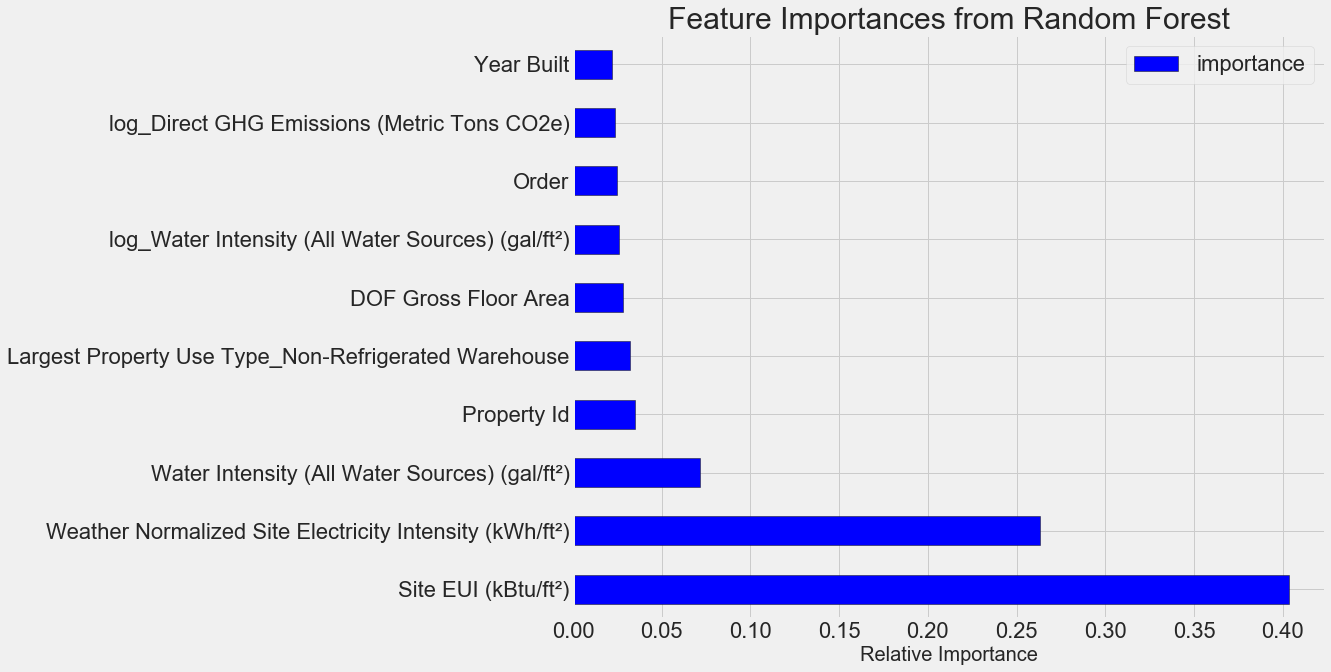

In [11]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', edgecolor = 'k', kind = 'barh', color = 'blue')

plt.xlabel('Relative Importance', size = 20)
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30)

## Feature Selection

In [13]:
most_importance_features = feature_results['feature'][:10]

indics = [list(train_features.columns).index(x) for x in most_importance_features]

X_reduced = X[:, indics]
X_test_reduced = X_test[:, indics]

print(X_reduced.shape)

(6622, 10)


In [16]:
lr = LinearRegression()

lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

lr.fit(X_reduced, y)
lr_reduced_pred=  lr.predict(X_test_reduced)

print("LR Full MAE = %0.4f" % mae(lr_full_pred, y_test))
print("LR Reduced MAE = %0.4f" % mae(y_test, lr_reduced_pred))

LR Full MAE = 13.4651
LR Reduced MAE = 15.1007
